# AI Bias in Healthcare

### Virginia Polytechnic Institute and State University

#### CS-5024 Ethics and Professionalism

#### Authors: 
 Diego Espinoza, Rithvik Gottimukkala, Rameshkumar Govindaraju, and Jonathan Mahoney

## Reseach

### Set up

Installing needed python packages

In [1]:
%pip install matplotlib sklearn pandas scikit-image

     |████████████████████████████████| 11.3 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 39.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 78.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 191 kB 78.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 74.2 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 78.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=0011abd00686e

In [2]:
import torchvision as thv
import torch 
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Compose, RandomCrop, Resize, Normalize
from torch.optim.lr_scheduler import ExponentialLR
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from skimage import io, color
import os

Checking if GPU is available if so make use of CUDA 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data Preprocessing

In [4]:
fitzDF = pd.read_csv('./fitzpatrick17k.csv') 
fitzDF.head(5)

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [5]:
percent_neoplastic = fitzDF[fitzDF['three_partition_label'] == 'non-neoplastic'].count() / fitzDF['three_partition_label'].count() * 100
percent_benign = fitzDF[fitzDF['three_partition_label'] == 'benign'].count() / fitzDF['three_partition_label'].count() * 100
percent_malignant = fitzDF[fitzDF['three_partition_label'] == 'malignant'].count() / fitzDF['three_partition_label'].count() * 100

print('Percentage of non-neoplastic: {}%'.format(percent_neoplastic.three_partition_label))
print('Percentage of benign: {}%'.format(percent_benign.three_partition_label))
print('Percentage of malignant: {}%'.format(percent_malignant.three_partition_label))

labels = 'non-neoplastic', 'benign', 'malignant'
sizes = [percent_neoplastic.three_partition_label, percent_benign.three_partition_label, percent_malignant.three_partition_label]
explode = (0.1, 0, 0)

Percentage of non-neoplastic: 72.87205163781142%
Percentage of benign: 13.47650358931049%
Percentage of malignant: 13.651444772878085%


##### Patient Diagnosis Pie Chart

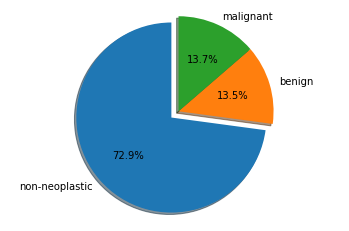

In [6]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [7]:
fitz6 = len(fitzDF[(fitzDF['fitzpatrick'] == 6) & (fitzDF['three_partition_label'] == 'malignant')])
fitz5 = len(fitzDF[(fitzDF['fitzpatrick'] == 5) & (fitzDF['three_partition_label'] == 'malignant')])
fitz4 = len(fitzDF[(fitzDF['fitzpatrick'] == 4) & (fitzDF['three_partition_label'] == 'malignant')])
fitz3 = len(fitzDF[(fitzDF['fitzpatrick'] == 3) & (fitzDF['three_partition_label'] == 'malignant')])
fitz2 = len(fitzDF[(fitzDF['fitzpatrick'] == 2) & (fitzDF['three_partition_label'] == 'malignant')])
fitz1 = len(fitzDF[(fitzDF['fitzpatrick'] == 1) & (fitzDF['three_partition_label'] == 'malignant')])

data = {'fitzpatrick': [6, 5, 4, 3, 2, 1],
        'malignant': [fitz6, fitz5, fitz4, fitz3, fitz2, fitz1]}

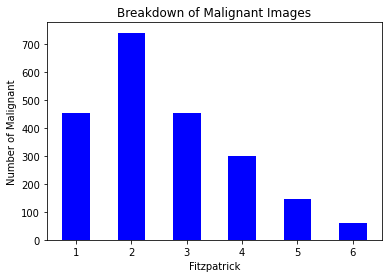

In [8]:
plt.bar(data['fitzpatrick'], data['malignant'], width=0.5, color='b')
plt.xlabel('Fitzpatrick')
plt.ylabel('Number of Malignant')
plt.title('Breakdown of Malignant Images')
plt.show()

In [9]:
malignant_fitzDF = fitzDF[fitzDF['three_partition_label'] == 'malignant']
malignantCount = len(malignant_fitzDF)
benign = fitzDF[fitzDF['three_partition_label'] == 'benign']
benignCount = len(benign)
neoplastic = fitzDF[fitzDF['three_partition_label'] == 'non-neoplastic']
neoplasticCount = len(neoplastic)

In [10]:
indices = fitzDF['Unnamed: 0'].values

In [11]:
transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
            ])

imgListOfTensors = []
if os.path.exists('./imgListOfTensors.pt'):
    imgListOfTensors = torch.load('./imgListOfTensors.pt')
else:
    for md5hash in fitzDF.md5hash:
        if os.path.exists('./finalfitz17k/' + md5hash + '.jpg'):

            img = io.imread('./finalfitz17k/' + md5hash + '.jpg')
            if(len(img.shape) < 3):
                img = color.gray2rgb(img)
            image = transform(img)
            imgListOfTensors += [image]
        else:
            fitzDF = fitzDF.drop(md5hash)
    imgListOfTensors = torch.stack(imgListOfTensors)
    torch.save(imgListOfTensors, './imgListOfTensors.pt')
print(imgListOfTensors.shape)

torch.Size([16577, 3, 224, 224])


In [12]:
diagnosis = fitzDF.three_partition_label.values

tempList = []

for i in range(len(diagnosis)):
    if diagnosis[i] == 'non-neoplastic':
        temp = [1, 0, 0]
    elif diagnosis[i] == 'benign':
        temp = [0, 1, 0]
    elif diagnosis[i] == 'malignant':
        temp = [0, 0, 1]
    tempList += [temp]
diagnosisNP = np.array(tempList)

In [13]:
xDataNP = imgListOfTensors.numpy()
yDataNP = diagnosisNP
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(xDataNP, yDataNP, indices, test_size=0.3, random_state=42)

train_data = TensorDataset(torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device))
test_data = TensorDataset(torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device))

In [14]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
        nn.Linear(2048, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3),
    ).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [15]:
EPOCHS = 50
batch_size = 64
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## Training 

In [16]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
def Train(model, loader, optimizer, criterion):
  epoch_loss = []
  epoch_acc = 0

  model.train()
  for data, labels in loader:
    optimizer.zero_grad()

    output = model(data)

    loss = criterion(output, labels.float())
    epoch_loss.append(loss.item())

    preds = output.argmax(dim=1)
    labels = labels.argmax(dim=1)
    epoch_acc += (preds == labels).cpu().sum()

    loss.backward()
    optimizer.step()
    
  return np.mean(epoch_loss), epoch_acc / len(loader.dataset)

In [18]:
def evaluate(model, loader, criterion, test=False):
  epoch_loss = []
  epoch_acc = 0
  predicted, expected = [], []

  model.eval()
  with torch.no_grad():
    for text, labels in loader:

      output = model(text)

      loss = criterion(output, labels.float())
      epoch_loss.append(loss.item())
    
      preds = output.argmax(dim=1)
      labels = labels.argmax(dim=1)
      epoch_acc += (preds == labels).cpu().sum()

      predicted.append(preds)
      expected.append(labels)

  if test:
    expected = np.array(torch.cat(expected).cpu(), dtype=float)
    predicted = np.array(torch.cat(predicted).cpu(), dtype=float)
    precision, recall, fscore, _ = precision_recall_fscore_support(expected, predicted, average='macro')
    accuracy = accuracy_score(expected, predicted)
    print('Scores:')
    print(f'Precision: {precision}, Recall: {recall}, Fscore: {fscore}, Accuracy: {accuracy}')

  return predicted, expected

In [19]:
train_loss = []
train_acc = []

for epoch in range(EPOCHS):
  trainEpochLoss, trainEpochAcc = Train(model, train_loader, optimizer, criterion)
  train_loss.append(trainEpochLoss)
  train_acc.append(trainEpochAcc)
  scheduler.step()
  print(f'Epoch: {epoch} Train Loss: {trainEpochLoss} Train Acc: {trainEpochAcc}')

Epoch: 0 Train Loss: 0.6925536614755241 Train Acc: 0.7402396202087402
Epoch: 1 Train Loss: 0.6428271186285914 Train Acc: 0.7551495432853699
Epoch: 2 Train Loss: 0.6180819908558335 Train Acc: 0.7634232640266418
Epoch: 3 Train Loss: 0.6040304701631241 Train Acc: 0.7668706178665161
Epoch: 4 Train Loss: 0.5793396914532172 Train Acc: 0.7766956686973572
Epoch: 5 Train Loss: 0.571127534900581 Train Acc: 0.781866729259491
Epoch: 6 Train Loss: 0.5548423268518395 Train Acc: 0.7866069078445435
Epoch: 7 Train Loss: 0.533594382401988 Train Acc: 0.7961733937263489
Epoch: 8 Train Loss: 0.5171115406639668 Train Acc: 0.8023787140846252
Epoch: 9 Train Loss: 0.494326702468303 Train Acc: 0.8113418817520142
Epoch: 10 Train Loss: 0.4548623298413187 Train Acc: 0.8272860646247864
Epoch: 11 Train Loss: 0.4444747978811106 Train Acc: 0.8307334184646606
Epoch: 12 Train Loss: 0.4418117741524185 Train Acc: 0.830474853515625
Epoch: 13 Train Loss: 0.4388632958765188 Train Acc: 0.8354735970497131
Epoch: 14 Train Loss:

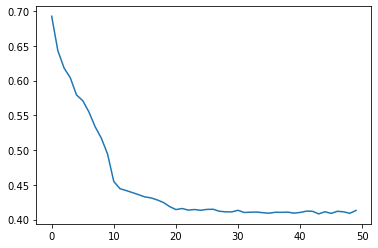

In [20]:
plt.plot(train_loss, label='Train Loss')
plt.show()

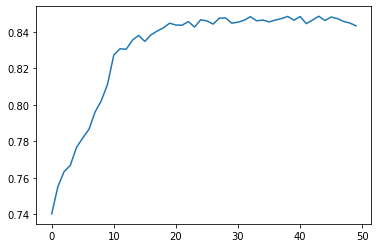

In [21]:
plt.plot(train_acc, label='Train Acc')
plt.show()

In [22]:
torch.cuda.empty_cache()

In [23]:
predicted, expected = evaluate(model, test_loader, criterion, test=True)

Scores:
Precision: 0.6933914559068461, Recall: 0.5624875603699553, Fscore: 0.600369971164366, Accuracy: 0.7954545454545454


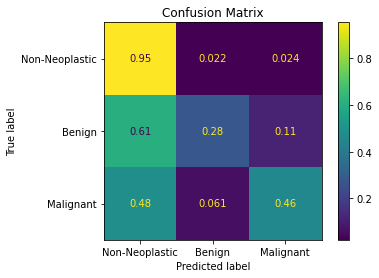

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(expected, predicted, labels=[0, 1, 2], normalize='true')
displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()


In [25]:
test_indices = list(test_indices)
test_indices.remove(test_indices[len(test_indices) - 1])
resultDF = pd.DataFrame(columns=['md5hash', 'predicted', 'expected', 'fitzpatrick', 'three_partition_label'])
tempDF = fitzDF[fitzDF['Unnamed: 0'].isin(test_indices)]
data = []
for index, indices in enumerate(test_indices):
    if len(predicted) - 1 >= index:
        data.append({
            'index': indices,
            'md5hash': tempDF[tempDF['Unnamed: 0'] == indices].md5hash.values[0],
            'predicted': predicted[index],
            'expected': expected[index],
            'fitzpatrick': tempDF[tempDF['Unnamed: 0'] == indices].fitzpatrick.values[0],
            'three_partition_label': tempDF[tempDF['Unnamed: 0'] == indices].three_partition_label.values[0]
        })

In [26]:
resultDF = resultDF.append(data, ignore_index=True)

/tmp/ipykernel_12/1548436551.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultDF = resultDF.append(data, ignore_index=True)


In [27]:
resultDF.head()

,md5hash,predicted,expected,fitzpatrick,three_partition_label,index
0,42011fa6b24713fc37c521ff2e50758a,0.0,0.0,3,non-neoplastic,10024.0
1,34becf085bc7a8e0a42fe577e90d10d9,1.0,0.0,2,benign,6140.0
2,b35d8e1757e938d5520dfd99ff8e0174,0.0,0.0,6,non-neoplastic,3999.0
3,1f3a8a1749c71d9fa471df71f6023a07,0.0,0.0,3,non-neoplastic,3165.0
4,6271a02a044e6a36995a66914c1f0be4,0.0,0.0,3,non-neoplastic,12840.0


In [28]:
fitz6 = resultDF[resultDF['fitzpatrick'] == 6]
fitz5 = resultDF[resultDF['fitzpatrick'] == 5]
fitz4 = resultDF[resultDF['fitzpatrick'] == 4]
fitz3 = resultDF[resultDF['fitzpatrick'] == 3]
fitz2 = resultDF[resultDF['fitzpatrick'] == 2]
fitz1 = resultDF[resultDF['fitzpatrick'] == 1]

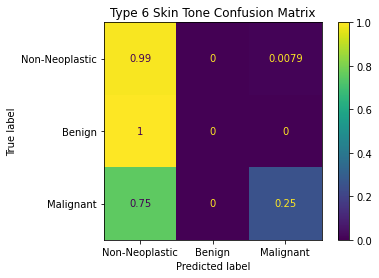

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fitz6Expected = np.array(fitz6['expected'].values, dtype=float)
fitz6Predicted = np.array(fitz6['predicted'].values, dtype=float)
matrix = confusion_matrix(fitz6Expected, fitz6Predicted, labels=[0, 1, 2], normalize='true')
displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')
plt.title('Type 6 Skin Tone Confusion Matrix')
plt.show()

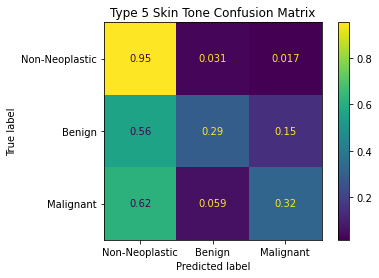

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fitz5Expected = np.array(fitz5['expected'].values, dtype=float)
fitz5Predicted = np.array(fitz5['predicted'].values, dtype=float)

matrix = confusion_matrix(fitz5Expected, fitz5Predicted, labels=[0, 1, 2], normalize='true')

displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')

plt.title('Type 5 Skin Tone Confusion Matrix')
plt.show()

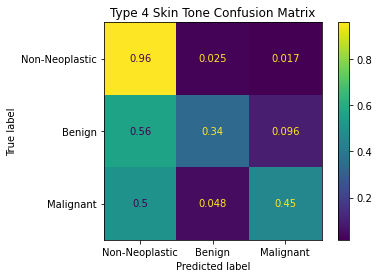

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fitz4Expected = np.array(fitz4['expected'].values, dtype=float)
fitz4Predicted = np.array(fitz4['predicted'].values, dtype=float)

matrix = confusion_matrix(fitz4Expected, fitz4Predicted, labels=[0, 1, 2], normalize='true')

displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')

plt.title('Type 4 Skin Tone Confusion Matrix')
plt.show()

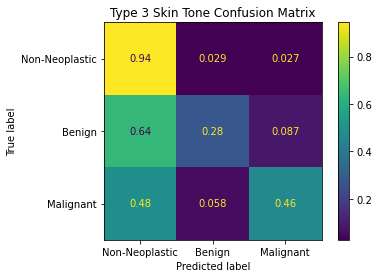

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fitz3Expected = np.array(fitz3['expected'].values, dtype=float)
fitz3Predicted = np.array(fitz3['predicted'].values, dtype=float)

matrix = confusion_matrix(fitz3Expected, fitz3Predicted, labels=[0, 1, 2], normalize='true')

displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')

plt.title('Type 3 Skin Tone Confusion Matrix')
plt.show()

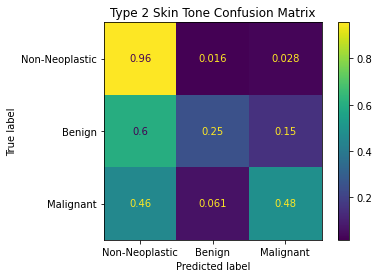

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fitz2Expected = np.array(fitz2['expected'].values, dtype=float)
fitz2Predicted = np.array(fitz2['predicted'].values, dtype=float)

matrix = confusion_matrix(fitz2Expected, fitz2Predicted, labels=[0, 1, 2], normalize='true')

displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')

plt.title('Type 2 Skin Tone Confusion Matrix')
plt.show()

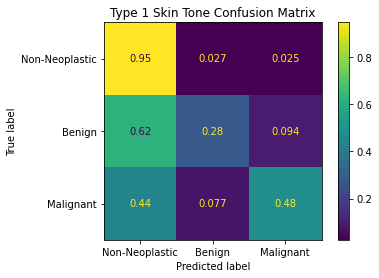

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fitz1Expected = np.array(fitz1['expected'].values, dtype=float)
fitz1Predicted = np.array(fitz1['predicted'].values, dtype=float)

matrix = confusion_matrix(fitz1Expected, fitz1Predicted, labels=[0, 1, 2], normalize='true')

displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')

plt.title('Type 1 Skin Tone Confusion Matrix')
plt.show()